In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

import numpy as np


import torch
from torch import distributions as distrs
from torch.distributions.multivariate_normal import MultivariateNormal

from IPython.display import clear_output

Обозначим вспомогательные функции:

In [2]:
# Красиво рисует двумерное распределение
def plot_2d_dots(dots, color='blue', label='None'):
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.scatter(dots[:, 0], dots[:, 1], s=1, c=color, label=label)

def create_distr(mu, sigma):
    return distrs.MultivariateNormal(mu, sigma)

# Оборачивает параметры распределения в торчевские тензоры
def get_parameters(mu=0., sigma=1.):
    train_mu = torch.Tensor([mu, mu])
    train_mu.requires_grad=True
    train_sigma = torch.Tensor([[sigma, 0.0],
                                [0.0, sigma]])
    train_sigma.requires_grad=True
    return train_mu, train_sigma

def sample(d, num):
    return d.sample(torch.Size([num]))

## Target distribution

In [3]:
mu = torch.Tensor([-5, -5])
sigma = torch.Tensor([[1., 0.0],
                      [0.0, 1.]])

target = create_distr(mu, sigma)
# x - samples from the target distribution
x = sample(target, 1000)
# px = p(x) = probability of target samples for the target distribution
px = target.log_prob(x).exp()

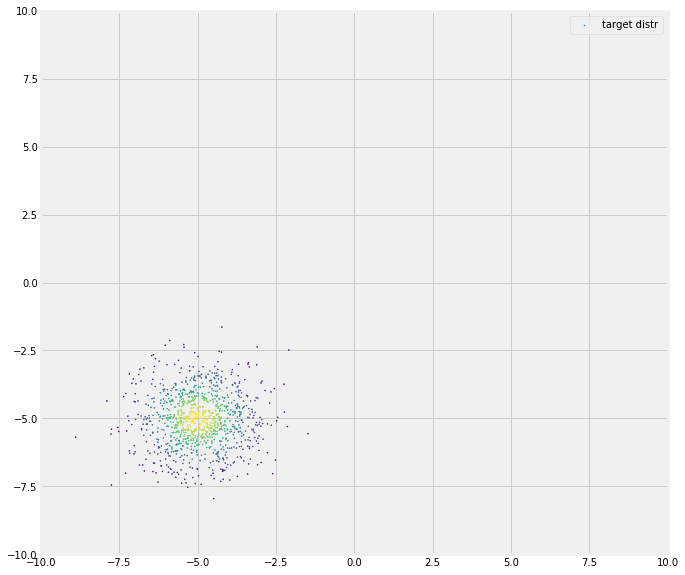

In [4]:
plt.figure(figsize=(10, 10))
plot_2d_dots(x, color=px, label='target distr')
plt.legend()
plt.show()

### Our approximation to the target distribution

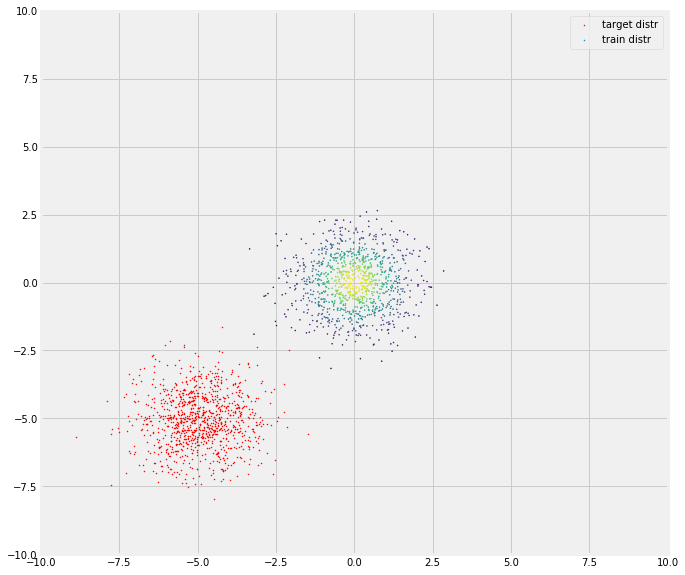

In [5]:
# starting points
train_mu, train_sigma = get_parameters()

Q = create_distr(train_mu, train_sigma)
q_sample = sample(Q, 1000)
plt.figure(figsize=(10, 10))
plot_2d_dots(x, color='r', label='target distr')
plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')

plt.legend()
plt.show()

In [7]:
def kl_loss(qx, px):
    # Clamp for the numerical stability 
    px, qx = px.clamp(min=1e-7), qx.clamp(min=1e-7)
    return torch.mean(px * (px.log() - qx.log())) # YOUR CODE

# train_mu and train_sigma are TRAINABLE parameters
train_mu, train_sigma = get_parameters()

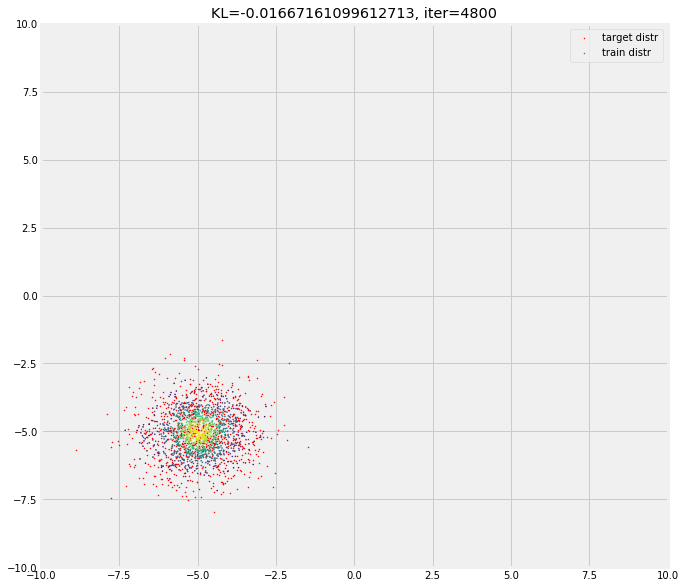

In [8]:
# Try replacing SGD with Adam
optim = torch.optim.SGD([train_mu, train_sigma], lr=0.1)

for i in range(5000):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    # qx = q(x) = probability of target samples for the train distribution
    qx = Q.log_prob(x).exp()
    loss = kl_loss(qx, px)
    loss.backward()
    optim.step()
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(x, color='r', label='target distr')
        # q_sample - samples from the train distribution, just for visualization
        q_sample = sample(Q, 1000)
        plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')
        plt.legend()
        plt.show()

# Mutimodal example

### Target distr

In [9]:
target1 = create_distr(torch.Tensor([-5, -5]), torch.Tensor([[1., 0.0], [0.0, 1.]]))
target2 = create_distr(torch.Tensor([4, 3]), torch.Tensor([[1., 0.0], [0.0, 1.]]))

x = torch.cat([sample(target1, 1000), sample(target2, 1000)])

px = target1.log_prob(x).exp() + target2.log_prob(x).exp()

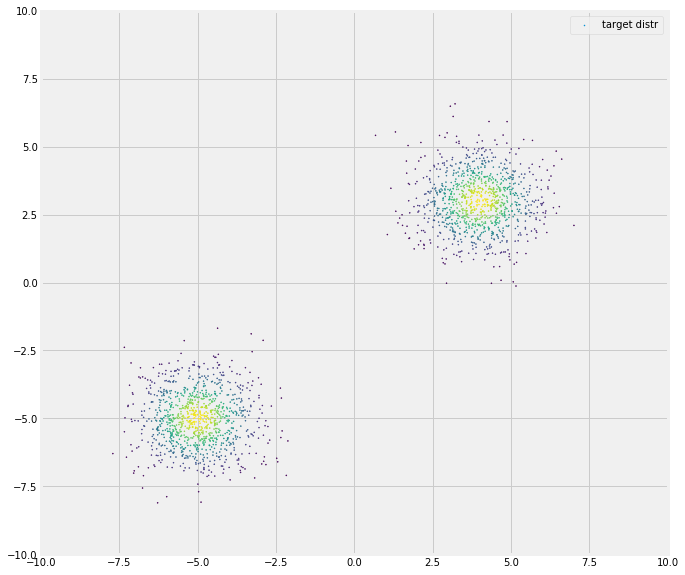

In [10]:
plt.figure(figsize=(10, 10))
plot_2d_dots(x, color=px, label='target distr')
plt.legend()
plt.show()

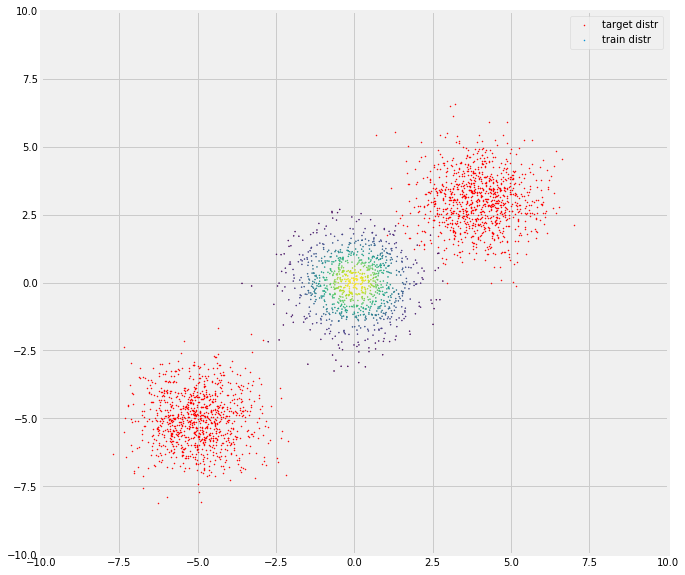

In [11]:
train_mu, train_sigma = get_parameters()

Q = create_distr(train_mu, train_sigma)
q_sample = sample(Q, 1000)
plt.figure(figsize=(10, 10))
plot_2d_dots(x, color='r', label='target distr')
plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')

plt.legend()
plt.show()

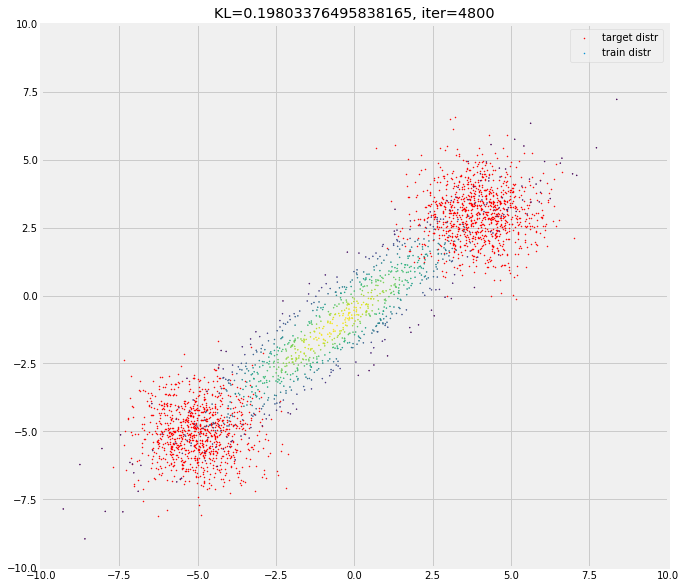

In [12]:
optim = torch.optim.SGD([train_mu, train_sigma], lr=0.1)

for i in range(5000):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    qx = Q.log_prob(x).exp()
    loss = kl_loss(qx, px)
    loss.backward()
    optim.step()
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(x, color='r', label='target distr')
        q_sample = sample(Q, 1000)
        plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')
        plt.legend()
        plt.show()

# Jensen–Shannon divergence

In [13]:
def js_div(qx, px):
    return 0.5 * kl_loss(px, 0.5*px+0.5*qx) + 0.5 * kl_loss(qx, 0.5*px+0.5*qx) # YOUR CODE

In [14]:
train_mu, train_sigma = get_parameters(1, 1)

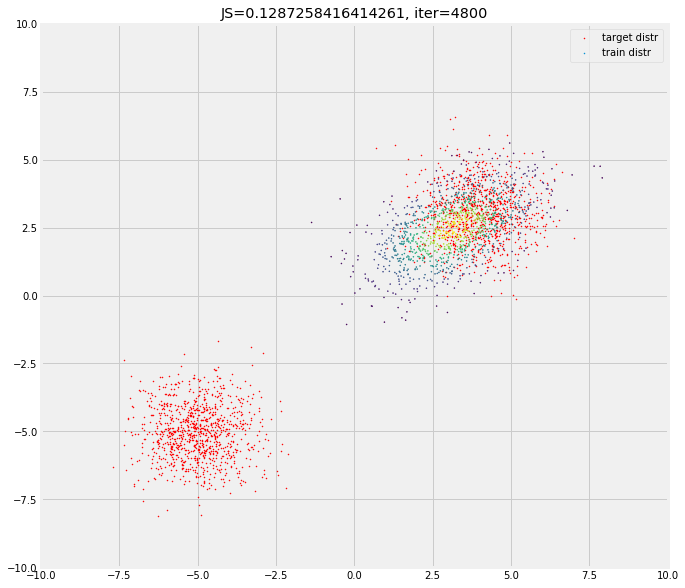

In [15]:
optim = torch.optim.SGD([train_mu, train_sigma], lr=0.1)

for i in range(5000):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    qx = Q.log_prob(x).exp()
    loss = js_div(qx, px)
    loss.backward()
    optim.step()
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'JS={loss.item()}, iter={i}')
        plot_2d_dots(x, color='r', label='target distr')
        q_sample = sample(Q, 1000)
        plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')
        plt.legend()
        plt.show()

### Least Squares  
*as in [here](https://www.arxiv-vanity.com/papers/1611.04076/)

In [25]:
def LSE_loss(qx, px):
    return torch.nn.MSELoss()(qx, px) # YOUR CODE

In [26]:
train_mu, train_sigma = get_parameters(1, 1)

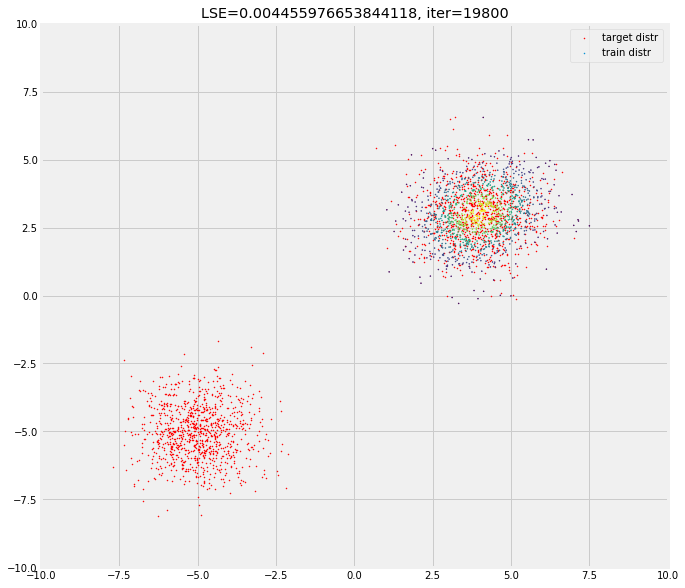

In [27]:
optim = torch.optim.SGD([train_mu, train_sigma], lr=0.5)

for i in range(20000):
    optim.zero_grad()
    Q = create_distr(train_mu, train_sigma)
    qx = Q.log_prob(x).exp()
    loss = LSE_loss(qx, px)
    loss.backward()
    optim.step()
    if i % 200 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'LSE={loss.item()}, iter={i}')
        plot_2d_dots(x, color='r', label='target distr')
        q_sample = sample(Q, 1000)
        plot_2d_dots(q_sample, color= Q.log_prob(q_sample).exp().detach(), label='train distr')
        plt.legend()
        plt.show()

# Inception Score

[here](https://arxiv.org/abs/1606.03498)


The idea of the IS is very simple. We can train a good classificator on the real data and use its predictions to score overall generation quality of our model

To do so:
1. Train a classifier *(for example inception network)*
2. Collect its label distribution for every generated image

![image](https://miro.medium.com/max/2976/1*X29oOi1Tzch2j6MuG9XS1Q.png)
![image](https://miro.medium.com/max/2812/1*t8lE_W4UKQ8jKgzxCAbHTA.png)

![image](https://miro.medium.com/max/3808/1*23gj_d3dxfm5FoKae_pc5Q.png)
![image.png](https://miro.medium.com/max/2772/1*xLq69Oj6_4NRZoWleg9K_Q.png)


![image](https://miro.medium.com/max/3472/1*hPEJY3MkOZyKFA6yEqzuyg.png)

###### marginal 

Идейно, чем ближе marginal распределение к равномерному, тем разнообразен и сбалансирован выход нашей модели. 

###### label 

Идейно, чем ближе label распределение к вырожденному, тем более "сфокусирован" выход нашей модели на каком-то классе

###### Overall

Теперь осталось только совместить все в одну цифру. Для этого мы можем использовать KL:

Inseption Score = $E_{x\sim P_\text{gen}} \text{exp}( KL( p_\text{label} \| p_\text{marginal}) ) $

Чем больше разница между label и marginal распределениями, тем больше становится Inseption Score, тем "лучше" себя показывает модель

Flaws in IS described here [here](https://arxiv.org/abs/1801.01973)

# Frechet Inception Distance


Похоже на IS, мы используем отдельный обученный классификатор для того чтобы получать фичи из сгенерированных изображений.

Главное - вместо распределения лейблов мы используем распределения функций активации с предпоследнего слоя, своеобразный feature representation для изображений

1. Считаем выход предпоследнего слоя классификатора для реальных и сгенерированных изображений.
2. Feature-wise считаем среднее и ковариацию распределения активация для реальных и сгенерированных изображений
3. Считаем (Fréchet distance)[https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance] между ними

Frecher Distance = $\|\mu_1 – \mu_2\|^2 + Tr(C_1 + C_2 - 2 * \text{sqrt}(C_1*C_2))$

Чем FID ниже, тем выше "качество" сгенерированных изображений


The authors of the score show that lower FID scores correlate with better-quality images when systematic distortions were applied such as the addition of random noise and blur.


![image](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-How-Increased-Distortion-of-an-Image-Correlates-with-High-FID-Score.png)